<a href="https://colab.research.google.com/github/snikhil17/REGex_Internship/blob/main/Team%20Project%20-%203/3_Modelling_and_Evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Business Problem**

- It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

# **Given Data**
- The datasets contains transactions made by credit cards in September 2013 by european cardholders. This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

- It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, ... V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-senstive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

# **Acknowledgements**

- The dataset has been collected and analysed during a research collaboration of Worldline and the Machine Learning Group (http://mlg.ulb.ac.be) of ULB (Université Libre de Bruxelles) on big data mining and fraud detection. More details on current and past projects on related topics are available on https://www.researchgate.net/project/Fraud-detection-5 and the page of the DefeatFraud project

# **Importing Required Libraries**

In [ ]:
# !pip install xgboost
!pip install optuna

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
plt.rcParams['figure.figsize'] = (16,8)
plt.style.use("fivethirtyeight")
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, train_test_split 
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')
from imblearn.combine import SMOTETomek
import optuna
import itertools
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

## **Loading the Data**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df_train= pd.read_csv('/content/drive/MyDrive/New Folder/Copy of creditcard_stratified.csv')
df_test= pd.read_csv('/content/drive/MyDrive/New Folder/Copy of test.csv')
df_train.head()

,id,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class,kfold
0,0,171306.0,2.168118,-1.731966,-0.101423,-1.516228,-1.762327,0.107145,-1.803075,0.087421,-0.617820,1.430516,-1.132033,-0.548229,0.989762,-1.007329,0.142895,-0.110690,0.292566,0.222226,-0.358004,-0.298250,-0.126096,0.104613,0.337718,0.583060,-0.529252,-0.273834,0.060092,-0.017113,52.00,0,4.0
1,1,62395.0,-0.514037,0.953548,1.639592,-0.149570,0.061661,-0.210378,0.545380,0.203165,-0.678399,-0.191564,1.707444,0.803937,-0.082876,0.374202,0.381713,0.042487,-0.293247,-0.374638,-0.132844,0.076307,-0.133674,-0.327980,0.025932,0.205276,-0.322368,0.070640,0.277572,0.109626,5.85,0,4.0
2,2,43463.0,-0.671869,-0.399551,1.649636,-2.278123,-0.484760,-1.164731,0.155846,-0.030425,1.440249,-1.829221,-0.583126,0.890476,0.592870,-0.457628,0.409242,-0.194237,-0.481948,0.095075,-0.063800,0.116415,0.210261,0.594446,0.184314,0.430021,-0.644314,-0.342088,0.171030,0.207153,70.00,0,3.0
3,3,157918.0,2.084298,0.103235,-1.613616,0.485971,0.264824,-1.411857,0.598777,-0.504130,0.496313,-0.078829,-0.784751,0.783872,0.424063,0.359565,-0.384585,-0.843043,-0.117172,-0.719843,0.226709,-0.239673,0.002001,0.293965,0.029691,0.090537,0.383237,-0.224996,-0.031261,-0.065743,1.00,0,1.0
4,4,67461.0,1.286755,-1.194764,1.503195,-0.353358,-1.869471,0.605151,-1.749865,0.461911,0.668069,0.467496,0.024983,-0.197757,-1.296228,-0.960619,-1.907411,0.911665,0.595563,-0.603601,1.410409,-0.027345,0.155647,0.710105,-0.129878,0.051088,0.449721,-0.038945,0.073214,0.011353,5.80,0,1.0


In [ ]:
ND_out=['V9','V10','V13','V15','V19','V20','V21','V22','V25','V27'] #by oberving the distribution diagrams

#normal distributed outliers treatment by [min :mean-3*(sigma) or above: mean+3*(sigma)]
j=0
ND_h=[]
ND_l=[]
for i in ND_out[:]:
    m=min(df_train[i].max(),abs(df_train[i].min()))
    ND_h.append(round(df_train[i].mean() + (m-((m//5)*1.25))*df_train[i].std(),1))
    ND_l.append(round(df_train[i].mean() - (m-((m//5)*1.25))*df_train[i].std(),1))
    new_df = df_train[(df_train[i] < ND_h[j]) & (df_train[i] > ND_l[j])]
    df_train[i] = np.where( df_train[i]>ND_h[j],ND_h[j],np.where( df_train[i]<ND_l[j],  ND_l[j],  df_train[i] ))
    j=j+1

SD_out=['V1','V2','V3','V4','V5','V6','V7','V8','V11','V12','V14','V16','V17','V18','V23','V26'] #by oberving the distribution diagrams
#Skewed distribution outliers treatment
for i in SD_out[:]:
    p25 = new_df[i].quantile(0.25)
    p75 = new_df[i].quantile(0.75)
    iqr=p75-p25
    ul = p75 + 1.5 * iqr
    ll = p25 - 1.5 * iqr
    new_df1 = new_df[new_df[i] < ul]#trimming
    #capping
    new_df[i] = np.where( 
    new_df[i] > ul,
    ul,
    np.where(
        new_df[i] < ll,
        ll,
        new_df[i]
            )
    )

OD_out=['V24','V28','Amount'] #by oberving the distribution diagrams

#Other distributed outliers treatment by percentile
for i in OD_out[:]:
    upper_limit = new_df1[i].quantile(0.99)
    lower_limit = new_df1[i].quantile(0.01)
    new_df2 = new_df1[(new_df1[i] <= upper_limit) & (new_df1[i] >= lower_limit)]#trimming
    #capping
    new_df1[i] = np.where(new_df1[i] >= upper_limit,
            upper_limit,
            np.where(new_df1[i] <= lower_limit,
            lower_limit,
            new_df1[i]))

# **Evaluation**
### **Confusion Matrix**

- **Confusion matrix**: A confusion matrix is a table that is often used to describe the performance of a classification model true positives (TP): These are cases in which we predicted yes.

- **true negatives (TN):** We predicted no, and they don't have the disease.

- **false positives (FP):** We predicted yes, but they don't actually have the disease. (Also known as a "Type I error.")

- **false negatives (FN):** We predicted no, but they actually do have the disease. (Also known as a "Type II error.")

- **precision** - What proportion of positive identifications was actually correct? 

- **recall** - What proportion of actual positives was identified correctly?

- **F1 Score:**
    - F1 Score is the weighted average of Precision and Recall
    - F1 is usually more useful than accuracy, especially if you have an uneven class distribution.



In [ ]:
# Function to plot Confusion Matrix (to be used later).
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.copper_r):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    # Hide grid lines
    plt.grid(False)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## **Feature Importance Function**


In [ ]:
# # Features imp
# features = list(new_df2)
# def feature_importance(model):
#   fold_importance_df = pd.DataFrame()
#   fold_importance_df["Feature"] = features
#   if model == 'model_rf':
#       fold_importance_df["importance"] = model_rf.feature_importances_
#   if model == 'model_xgb':
#       fold_importance_df["importance"] = model_xgb.feature_importances_    
#   fold_importance_df["fold"] = new_df2['kfold'] + 1
#   feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)    


# # Feat imp plt
#   feature_importance_df = pd.DataFrame()

#   cols = (feature_importance_df[["Feature", "importance"]]
#       .groupby("Feature")
#       .mean()
#       .sort_values(by="importance", ascending=False)[:30].index)
#   best_features = feature_importance_df.loc[feature_importance_df.Feature.isin(cols)]

#   plt.figure(figsize=(10,10))
#   sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance",ascending=False),
#           edgecolor=('white'), linewidth=2, palette="rocket")
#   plt.title(str(model)+' Features importance (averaged/folds)', fontsize=18)
#   plt.tight_layout()


## **Preprocessing** 

In [ ]:
# Normalizing Amount
new_df2['normalized_amount']=StandardScaler().fit_transform(new_df2['Amount'].values.reshape(-1,1))
df_test['normalized_amount'] = StandardScaler().fit_transform(df_test['Amount'].values.reshape(-1,1))
# Dropping the actual Amount column from the dataset.
new_df2=new_df2.drop(['Amount'],axis=1)
df_test=df_test.drop(['Amount'],axis=1)


# Normalizing Time
new_df2['normalized_time']=StandardScaler().fit_transform(new_df2['Time'].values.reshape(-1,1))
df_test['normalized_time'] = StandardScaler().fit_transform(df_test['Time'].values.reshape(-1,1))
# Dropping the actual Amount column from the dataset.
new_df2=new_df2.drop(['Time'],axis=1)
df_test=df_test.drop(['Time'],axis=1)

useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]

## **Modelling Deep Neural Model**
- Neural networks reflect the behavior of the human brain, allowing computer programs to recognize patterns and solve common problems in the fields of AI, machine learning, and deep learning.
- Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons signal to one another.

- Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

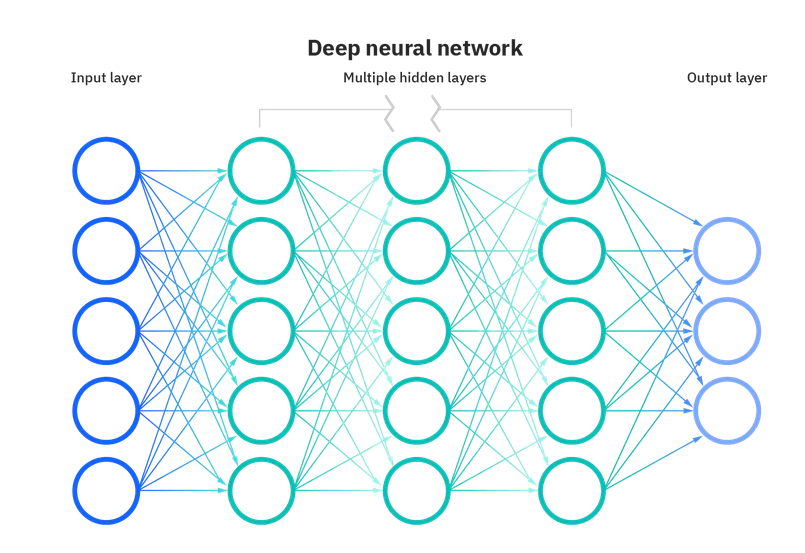

- Neural networks rely on training data to learn and improve their accuracy over time. However, once these learning algorithms are fine-tuned for accuracy, they are powerful tools in computer science and artificial intelligence, allowing us to classify and cluster data at a high velocity. Tasks in speech recognition or image recognition can take minutes versus hours when compared to the manual identification by human experts. One of the most well-known neural networks is Google’s search algorithm.

In [ ]:
%%time
useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]
# df_test = df_test[useful_features]

final_test_predictions_mp_list = []#to store final test predictions
final_test_predictions_mp = {} #to store final test predictions
final_valid_predictions_mp = {} # to store final validation predictions
scores = [] #to store the scores

# using for loop for 5 folds XGBoost
for fold in range(5):
    
    # Making all values which are not equal to present fold as training set
    xtrain =  new_df2[new_df2.kfold != fold]
    # Making all values which are equal to present fold as Validation set
    xvalid = new_df2[new_df2.kfold == fold]
    # cMaking copy of test set
    xtest = df_test.copy()
    
    #Creating keys for the dictionary containing valid predictions
    valid_ids = xvalid['id'].values.tolist()
    test_ids = xtest['id'].values.tolist()

    #creating ytrain and yvalid
    ytrain = xtrain.Class
    yvalid = xvalid.Class
    ytest = xtest.Class
    
    #creating xtrain and xvalid
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]

    smk = SMOTETomek(random_state=42)
    xtrain,ytrain=smk.fit_sample(xtrain,ytrain)
    xvalid,yvalid=smk.fit_sample(xvalid,yvalid)
    xtest,ytest=smk.fit_sample(xtest,ytest)
    
    
    model_mp= MLPClassifier(random_state=7,tol=1e-4,max_iter=20)
    model_mp.fit(xtrain,ytrain)
    

    preds_valid = model_mp.predict_proba(xvalid)[:, 1]
    test_preds = model_mp.predict_proba(xtest)[:, 1]    
    final_test_predictions_mp_list.append(test_preds)
    final_valid_predictions_mp.update(dict(zip(valid_ids, preds_valid)))
    final_test_predictions_mp.update(dict(zip(test_ids, test_preds)))
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)
    scores.append(roc_auc_score_valid)
    
    
print(np.mean(scores), np.std(scores))
final_valid_predictions_mp = pd.DataFrame.from_dict(final_valid_predictions_mp, orient="index").reset_index()
final_valid_predictions_mp.columns = ["id", "pred_mp"]
final_valid_predictions_mp.to_csv("train_pred_mp.csv", index=False)


final_test_predictions_mp = pd.DataFrame.from_dict(final_test_predictions_mp, orient="index").reset_index()
final_test_predictions_mp.columns = ["id", "pred_mp"]
final_test_predictions_mp.to_csv("test_pred_mp.csv", index=False)

Fold 0 AUC_valid:  0.9930996403418215
Fold 1 AUC_valid:  0.9697087611961887
Fold 2 AUC_valid:  0.9883346413342087
Fold 3 AUC_valid:  0.9876994947881805
Fold 4 AUC_valid:  0.9895321146713101
0.9856749304663419 0.00819872759009832


# **Modelling - XGBoost**

In [ ]:
%%time
useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]
# df_test = df_test[useful_features]

final_test_predictions_xgb_list = []#to store final test predictions
final_test_predictions_xgb = {} #to store final test predictions
final_valid_predictions_xgb = {} # to store final validation predictions
scores = [] #to store the scores

# using for loop for 5 folds XGBoost
for fold in range(5):
    
    # Making all values which are not equal to present fold as training set
    xtrain =  new_df2[new_df2.kfold != fold]
    # Making all values which are equal to present fold as Validation set
    xvalid = new_df2[new_df2.kfold == fold]
    # cMaking copy of test set
    xtest = df_test.copy()
    
    #Creating keys for the dictionary containing valid predictions
    valid_ids = xvalid['id'].values.tolist()
    test_ids = xtest['id'].values.tolist()

    #creating ytrain and yvalid
    ytrain = xtrain.Class
    yvalid = xvalid.Class
    ytest = xtest.Class
    
    #creating xtrain and xvalid
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]

    smk = SMOTETomek(random_state=42)
    xtrain,ytrain=smk.fit_sample(xtrain,ytrain)
    xvalid,yvalid=smk.fit_sample(xvalid,yvalid)
    xtest,ytest=smk.fit_sample(xtest,ytest)
    
    
    model_xgb = XGBClassifier(n_estimators  = 500, random_state= 7, 
            tree_method="gpu_hist",
            gpu_id=0,
            predictor="gpu_predictor"
            )
    model_xgb.fit(xtrain, 
            ytrain,
            eval_set=[(xvalid, yvalid)],
            early_stopping_rounds=200,
            verbose=500,eval_metric= 'auc',
        )

    preds_valid = model_xgb.predict_proba(xvalid)[:, 1]
    test_preds = model_xgb.predict_proba(xtest)[:, 1]    
    final_test_predictions_xgb_list.append(test_preds)
    final_valid_predictions_xgb.update(dict(zip(valid_ids, preds_valid)))
    final_test_predictions_xgb.update(dict(zip(test_ids, test_preds)))
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)
    scores.append(roc_auc_score_valid)
    
    
print(np.mean(scores), np.std(scores))

[0]	validation_0-auc:0.990574
Will train until validation_0-auc hasn't improved in 200 rounds.
Stopping. Best iteration:
[285]	validation_0-auc:0.999181

Fold 0 AUC_valid:  0.9991807587351027
[0]	validation_0-auc:0.97941
Will train until validation_0-auc hasn't improved in 200 rounds.
[499]	validation_0-auc:0.997184
Fold 1 AUC_valid:  0.9974218671736784
[0]	validation_0-auc:0.969219
Will train until validation_0-auc hasn't improved in 200 rounds.
[499]	validation_0-auc:0.996026
Fold 2 AUC_valid:  0.9961329374666227
[0]	validation_0-auc:0.988506
Will train until validation_0-auc hasn't improved in 200 rounds.
[499]	validation_0-auc:0.998154
Fold 3 AUC_valid:  0.998208621073457
[0]	validation_0-auc:0.971257
Will train until validation_0-auc hasn't improved in 200 rounds.
[499]	validation_0-auc:0.994036
Fold 4 AUC_valid:  0.9940595865567328
0.9970007542011187 0.0017772040559370325


## **Evaluation of XGBoost model**

Confusion matrix, without normalization
[[28149     7]
 [ 1191 26965]]


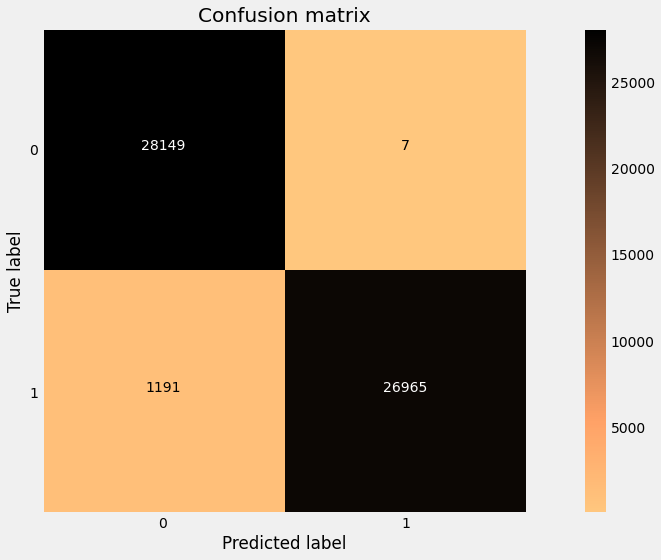

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     28156
           1       1.00      0.96      0.98     28156

    accuracy                           0.98     56312
   macro avg       0.98      0.98      0.98     56312
weighted avg       0.98      0.98      0.98     56312



In [ ]:
cnf_matrix=metrics.confusion_matrix(ytest,(np.mean(np.column_stack(final_test_predictions_xgb_list), axis=1)).round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()


print(classification_report(ytest,(np.mean(np.column_stack(final_test_predictions_xgb_list), axis=1)).round()))

# **Model - Random Forest**




In [ ]:
%%time
useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]
# df_test = df_test[useful_features]

final_test_predictions_rf_list = []
final_test_predictions_rf = {} #to store final test predictions
final_valid_predictions_rf = {} # to store final validation predictions
scores = [] #to store the scores

# using for loop for 5 folds XGBoost
for fold in range(5):
    
    # Making all values which are not equal to present fold as training set
    xtrain =  new_df2[new_df2.kfold != fold]
    # Making all values which are equal to present fold as Validation set
    xvalid = new_df2[new_df2.kfold == fold]
    # cMaking copy of test set
    xtest = df_test.copy()
    
    #Creating keys for the dictionary containing valid predictions
    valid_ids = xvalid['id'].values.tolist()
    test_ids = xtest['id'].values.tolist()

    #creating ytrain and yvalid
    ytrain = xtrain.Class
    yvalid = xvalid.Class
    ytest = xtest.Class
    
    #creating xtrain and xvalid
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]

    smk = SMOTETomek(random_state=42)
    xtrain,ytrain=smk.fit_sample(xtrain,ytrain)
    xvalid,yvalid=smk.fit_sample(xvalid,yvalid)
    xtest,ytest=smk.fit_sample(xtest,ytest)
    
    model_rf = RandomForestClassifier(n_estimators = 30,criterion = 'entropy',random_state= 5) #n_estimators means Weak learners and use entropy to get depth of the tree.
    model_rf.fit(xtrain, ytrain)

    preds_valid = model_rf.predict_proba(xvalid)[:, 1]
    test_preds = model_rf.predict_proba(xtest)[:, 1]    
    final_test_predictions_rf_list.append(test_preds)
    final_valid_predictions_rf.update(dict(zip(valid_ids, preds_valid)))
    final_test_predictions_rf.update(dict(zip(test_ids, test_preds)))
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)
    scores.append(roc_auc_score_valid)
    
    
print(np.mean(scores), np.std(scores))

Fold 0 AUC_valid:  0.9861073324532099
Fold 1 AUC_valid:  0.9747709636088303


## **Evaluation of Random Forest model**

Confusion matrix, without normalization
[[28152     4]
 [ 1790 26366]]


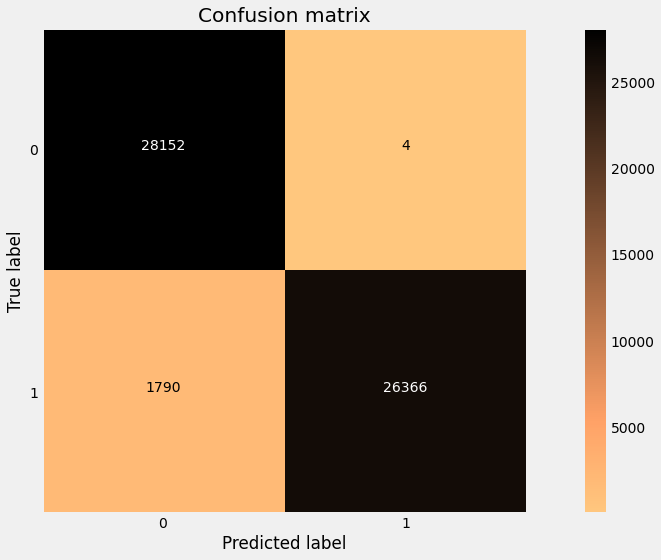

              precision    recall  f1-score   support

           0       0.94      1.00      0.97     28156
           1       1.00      0.94      0.97     28156

    accuracy                           0.97     56312
   macro avg       0.97      0.97      0.97     56312
weighted avg       0.97      0.97      0.97     56312



In [ ]:
cnf_matrix=metrics.confusion_matrix(ytest,(np.mean(np.column_stack(final_test_predictions_rf_list), axis=1)).round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()


print(classification_report(ytest,(np.mean(np.column_stack(final_test_predictions_rf_list), axis=1)).round()))

## **Voting Classifier**
- This type of ensemble is one of the most intuitive and easy to understand. The Voting Classifier is a homogeneous and heterogeneous type of Ensemble Learning, that is, the base classifiers can be of the same or different type. As mentioned earlier, this type of ensemble also works as an extension of bagging (e.g. Random Forest).

- The architecture of a Voting Classifier is made up of a number “n” of ML models, whose predictions are valued in two different ways: hard and soft. In hard mode, the winning prediction is the one with “the most votes”. In Figure 2 we see an example of how the Voting Classifier works in hard mode.

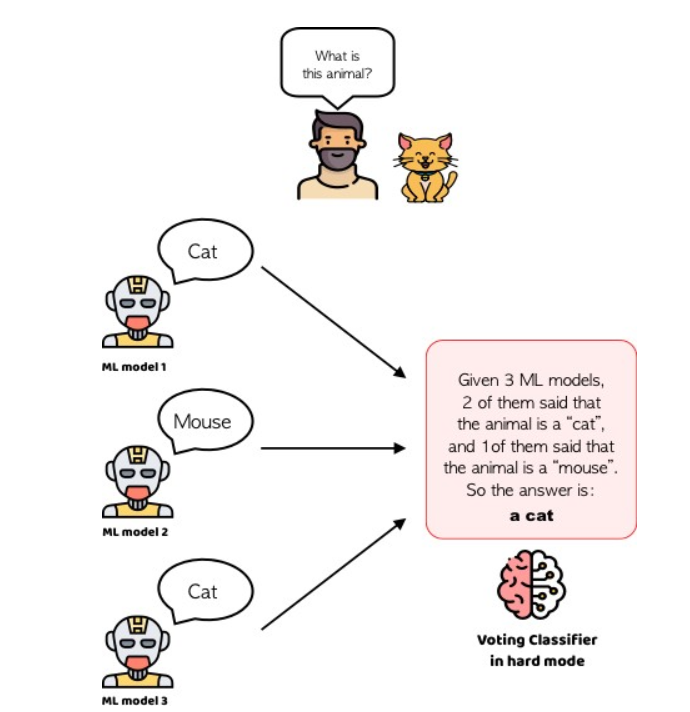

- On the other hand, the Voting Classifier in soft mode considers the probabilities thrown by each ML model, these probabilities will be weighted and averaged, consequently the winning class will be the one with the highest weighted and averaged probability. In Figure 3 we see an example of how the Voting Classifier works in the soft mode.

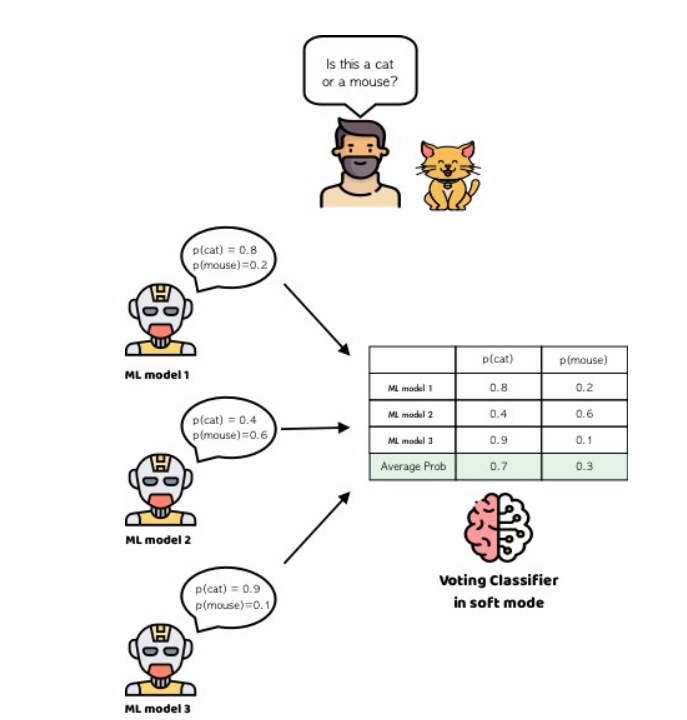

In [ ]:
useful_features = [c for c in new_df2.columns if c not in ("id","Class", "kfold")]
# df_test = df_test[useful_features]
labels = ['ANN', 'XGBoostClassifier', 'RandomForestClassifier']

final_test_predictions_eclf = [] #to store final test predictions
final_valid_predictions_eclf = {} # to store final validation predictions
scores = [] #to store the scores

# using for loop for 5 folds XGBoost
for fold in range(5):
    
    # Making all values which are not equal to present fold as training set
    xtrain =  new_df2[new_df2.kfold != fold]
    # Making all values which are equal to present fold as Validation set
    xvalid = new_df2[new_df2.kfold == fold]
    # cMaking copy of test set
    xtest = df_test.copy()
    
    #Creating keys for the dictionary containing valid predictions
    valid_ids = xvalid['id'].values.tolist()

    #creating ytrain and yvalid
    ytrain = xtrain.Class
    yvalid = xvalid.Class
    ytest = xtest.Class
    
    #creating xtrain and xvalid
    xtrain = xtrain[useful_features]
    xvalid = xvalid[useful_features]
    xtest = xtest[useful_features]

    smk = SMOTETomek(random_state=42)
    xtrain,ytrain=smk.fit_sample(xtrain,ytrain)
    xvalid,yvalid=smk.fit_sample(xvalid,yvalid)
    xtest,ytest=smk.fit_sample(xtest,ytest)
    
    eclf = VotingClassifier(estimators=[ (labels[0], model_mp), (labels[1], model_xgb), (labels[2], model_rf)], voting='soft')
    eclf.fit(xtrain, ytrain)

    preds_valid = eclf.predict_proba(xvalid)[:, 1]
    test_preds = eclf.predict_proba(xtest)[:, 1]    
    final_test_predictions_eclf.append(test_preds)
    roc_auc_score_valid = metrics.roc_auc_score(yvalid, preds_valid)
    print(f'Fold {fold} AUC_valid: ', roc_auc_score_valid)
    scores.append(roc_auc_score_valid)
    
    
print(np.mean(scores), np.std(scores))

Fold 0 AUC_valid:  0.9992799002855578
Fold 1 AUC_valid:  0.997159368475128
Fold 2 AUC_valid:  0.9950228928353599
Fold 3 AUC_valid:  0.9981806219828018
Fold 4 AUC_valid:  0.9946144114927634
0.9968514390143222 0.0017948172789021418


Confusion matrix, without normalization
[[28138    18]
 [  826 27330]]


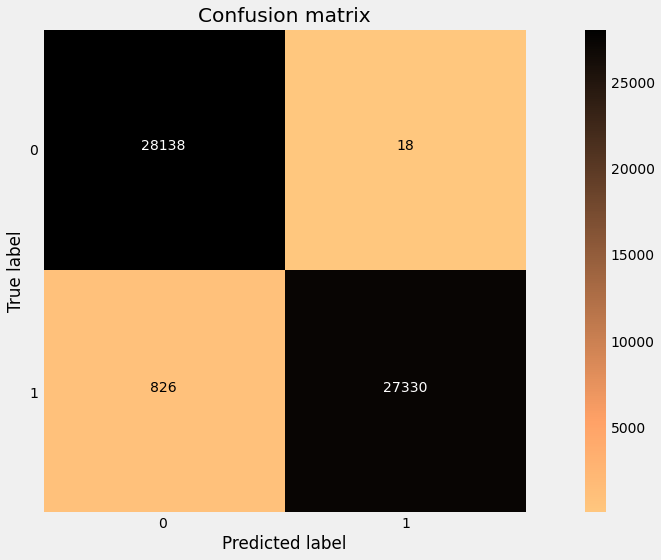



              precision    recall  f1-score   support

           0       0.97      1.00      0.99     28156
           1       1.00      0.97      0.98     28156

    accuracy                           0.99     56312
   macro avg       0.99      0.99      0.99     56312
weighted avg       0.99      0.99      0.99     56312



In [ ]:
cnf_matrix=metrics.confusion_matrix(ytest,(np.mean(np.column_stack(final_test_predictions_eclf), axis=1)).round())
plot_confusion_matrix(cnf_matrix,classes=[0,1])
plt.show()
print('\n')

print(classification_report(ytest,(np.mean(np.column_stack(final_test_predictions_eclf), axis=1)).round()))

